# Visualizing Decision Boundaries

We use a simple classification task, over 2D mixture of Gaussian data, to visualize the decision boundaries of some of the most common used classification algorithms.

**Classifiers**

   - Random Forest
   - Logistic Regression
   - Gaussian naive Bayes
   - kNN
   - Support Vector Classifier

We will also compare the results of the different classifiers with the ones of the optimal [Bayes classifier](https://en.wikipedia.org/wiki/Bayes_classifier).

## Navigation

1. [Auxiliary Functions](#Auxiliary-Functions)
1. [Data](#Data)
1. [Boundaries](#Boundaries)

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
from itertools import product
# vis
from plotnine import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

## Auxiliary Functions

[Top](#Navigation)

In [3]:
def gen_data(ns = [100, 100, 100],
             means = [(0,0), (.5,1), (1, .5)],
             covs = [[[.1, .05], [.05, .1]],
                     [[.1, .05], [.05, .1]],
                     [[.1, .05], [.05, .1]]],
             clusters = None):
    """
    Generates data from 2-D multivariate normal distribution.
    
    Parameters
    ----------
    ns: number of samples for each cluster
    means: list of cluster centroids
    covs: list of covariance matrices.
    clusters: optional. list with cluster names.
    
    Returns
    -------
    pd.DataFrame with sampled data and list of (cluster_name, pdf) tuples
    """
    assert (len(ns) == len(means) == len(covs)), "Length of all arrays must be equal."
    
    cluster_name = range(len(ns))
    if clusters is not None:
        assert(len(ns) == len(clusters))
        cluster_name = clusters
    data = pd.DataFrame()
    cluster_pdf = []
    for indx, n in enumerate(ns):
        mean = means[indx]
        cov = covs[indx]
        curr_sample = np.random.multivariate_normal(mean, cov, n)
        curr_df = pd.DataFrame(curr_sample, 
                               columns=['x_{}'.format(i) for i in range(len(mean))])
        curr_df['cluster'] = cluster_name[indx]
        data = data.append(curr_df, ignore_index = True)
        # dict with clusters pdf
        cluster_pdf.append((cluster_name[indx], multivariate_normal(mean, cov).pdf))
    data.cluster = data.cluster.astype('category')
    return data, cluster_pdf

In [4]:
# custom theme, colors and shapes
my_theme = (theme_void() +
                theme(
                axis_line=element_line(size=.75),
                axis_ticks=element_line(size=.75),
                axis_title=element_text(),
                )
           )
viridis = ["#fde725ff", "#440154ff", "#23988aff"]
shapes = ['o', '^', 's']

def plot_data(data, 
              xname = "x_0", 
              yname = "x_1", 
              title = "", 
              xlab = "", 
              ylab = "", 
              color_var = "cluster",
              shape_var = "cluster",
              colors = viridis, 
              shapes = shapes,
              figure_size = (8, 6)):
    """
    Plot 2-D (labeled) data.
    Note: If you use more than 3 clusters, please supply colors and shapes.
    
    Parameters
    ----------
    data: data to plot.
    xname: name of x-axis variable
    yname: name of y-axes variable
    title: plot title
    xlab: x-axis label
    ylab: y-axis label
    color_var: name of color variable
    shape_var: name of shape variable
    colors: list of colors
    shapes: list of shapes
    figure_size: figure size
    
    Returns
    -------
    plotnine figure
    """
    p = (ggplot(data, aes(xname, yname, color = color_var, shape = shape_var))
            + geom_point()
            + scale_color_manual(values = colors, name = "Cluster")
            + scale_shape_manual(values = shapes, name = "Cluster")
            + labs(x = xlab, y = ylab, 
                   title = title)
            + my_theme
            + theme(figure_size = figure_size)
        )
    return p

In [5]:
def get_grid(data, N, xname = 'x_0', yname = 'x_1'):
    """
    Generate grid of size N*N.
    
    Parameters
    ----------
    data: pd.DataFrame with columns xname, yname
    N: grid size
    xname: name of x-axis variable
    yname: name of y-axis variable
    
    Returns
    -------
    pd.DataFrame with grid of (xname, yname) values
    """
    features = [xname, yname]
    x0_range, x1_range = data[features].apply(lambda x : (x.min(), x.max()))
    grid = product(np.linspace(x0_range[0], x0_range[1], num=N),
                   np.linspace(x1_range[0], x1_range[1], num=N))
    data_grid = pd.DataFrame([row for row in grid], columns=features)
    return data_grid

In [6]:
def get_decisions(clf, data_grid, model_name = None):
    """
    Compute decision for a given classifier
    
    Parametres
    ----------
    clf: trained classifier
    data_grid: pd.DataFrame
    model_name: name of classifier
    
    Returns
    -------
    pd.DataFrame
    """
    data_grid['pred'] = pd.Series(clf.predict(data_grid)).astype('category')
    data_grid['method'] = model_name
    return data_grid

In [7]:
def plot_boundries(clfs, data, N, 
                   model_name = None,
                   xname = "x_0", 
                   yname = "x_1", 
                   title = "", 
                   xlab = "", 
                   ylab = "",
                   color_var = "cluster",
                   shape_var = "cluster", 
                   colors = viridis, 
                   shapes = ['o', '^', 's'],
                   figure_size = (8, 6)):
    """
    Plot data points and decision boundaries
    
    Parameters
    ----------
    clfs: classifier or dict with "name":classifier.
    data: pd.DataFrame with xname, yname columns
    N: grid size
    model_name: classifiers name. Only relevent if a single classifier is passed as clfs.
    xname: name of x-axis variable
    yname: name of y-axes variable
    title: plot title
    xlab: x-axis label
    ylab: y-axis label
    color_var: name of color variable
    shape_var: name of shape variable
    colors: list of colors
    shapes: list of shapes
    figure_size: figure size
    
    Returns
    -------
    plotnine figure
    """
    data_grid = get_grid(data, N, xname, yname)
    
    if isinstance(clfs, dict):
        to_plot = pd.concat((get_decisions(model, data_grid.copy(), model_name) \
                                       for model_name, model in clfs.items()))
    else:
        to_plot = get_decisions(clfs, data_grid, model_name)
    # plot
    p = (ggplot(to_plot, aes(xname, yname, color = 'pred'))
        + geom_point(size = .001)
        + scale_color_manual(values = colors, name = shape_var) #  guide=False,
        + labs(x = xlab, y = ylab, 
               title = title)
        + my_theme
        + facet_wrap('method', nrow = 3)
        + theme(figure_size = figure_size)
        )
    p += (geom_point(data = data, mapping = aes(xname, yname, 
                                                color = color_var, 
                                                shape = shape_var),
                    fill="black", size = 2, inherit_aes = False)
         )
    return p

In [8]:
def bayes_clf(clusters_pdf, X):
    """
    Compute densities and decisions for the Bayes classifier
    
    Parameters
    ----------
    clusters_pdf: list of (cluster_name, pdf) tupples
    X: array like of 2D points.
    
    Returns
    -------
    densities, decisions
    """
    probs = np.zeros((X.shape[0], len(clusters_pdf)))
    for i, (name, pdf) in enumerate(clusters_pdf):
        probs[:, i] = pdf(X)
        
    clusters = np.array([name for (name, pdf) in clusters_pdf])
    argmax = np.argmax(probs, axis = 1)
    return probs, clusters[argmax]

In [9]:
def plot_boundries_w_bayes(clfs, data, grid_size, clusters_pdf,
                           bayes_grid_size = 1000,
                           model_name = None,
                           xname = "x_0", 
                           yname = "x_1",
                           boundary_color = "#d10000",
                           linewidths = 2,
                           **kwargs):
    """
    Plot data points, decision boundaries and Bayes classifier boundaries
    
    Parameters
    ----------
    clfs: classifier or dict with "name":classifier.
    data: pd.DataFrame with xname, yname columns
    grid_size: grid size
    clusters_pdf: list of (cluster_name, pdf) tupples
    bayes_grid_size: grid size for Bayes classifier
    model_name: classifiers name. Only relevent if a single classifier is passed as clfs.
    xname: name of x-axis variable
    yname: name of y-axes variable
    boundary_color: Bayes classifier boundaries color
    linewidths: Bayes classifier boundaries line widths
    
    Returns
    -------
    plotnine figure
    """
    p = plot_boundries(clfs, data, grid_size, **kwargs)
    g = get_grid(data, bayes_grid_size)
    features = [xname, yname]
    prob, clusters = bayes_clf(clusters_pdf, g[features])
    
    fig = p.draw()
    axs = fig.get_axes()
    
    shapes = (bayes_grid_size, bayes_grid_size)
    levels = None if (np.unique(clusters).size > 2) else (0,)
    for ax in axs:
        ax.contour(np.array(g.x_0).reshape(shapes), 
                   np.array(g.x_1).reshape(shapes), 
                   np.array(clusters).reshape(shapes), 
                   levels = levels, 
                   colors = boundary_color,
                   linewidths = linewidths
                  )
    return fig

## Data

[Top](#Navigation)

Sample mixed Gaussian data:

   - Linear boundaries data
   - Non-linear boundaries data

In [10]:
n = 300                           # number of obs. for each cluster
n_clusters = 3                    # number of clusters
covs=[[[0.1, 0.05], [0.05, 0.1]], 
      [[0.1, 0.02], [0.02, 0.1]], 
      [[0.1, 0.02], [0.02, 0.1]]] # covariance structure for the non-linear boundaries data 

linear_data, lin_cluster_pdf = gen_data(ns = [n] * n_clusters)

non_linear_data, non_lin_cluster_pdf = gen_data(ns = [n] * n_clusters, clusters=[0, 1, 1], covs=covs)

Plot for the linear boundaries data:

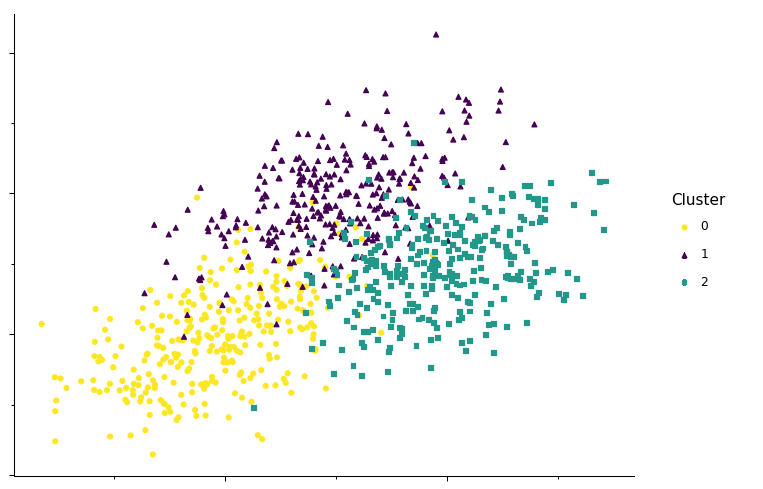

<ggplot: (289678263)>

In [11]:
plot_data(linear_data)

Plot for the non-linear boundaries data:

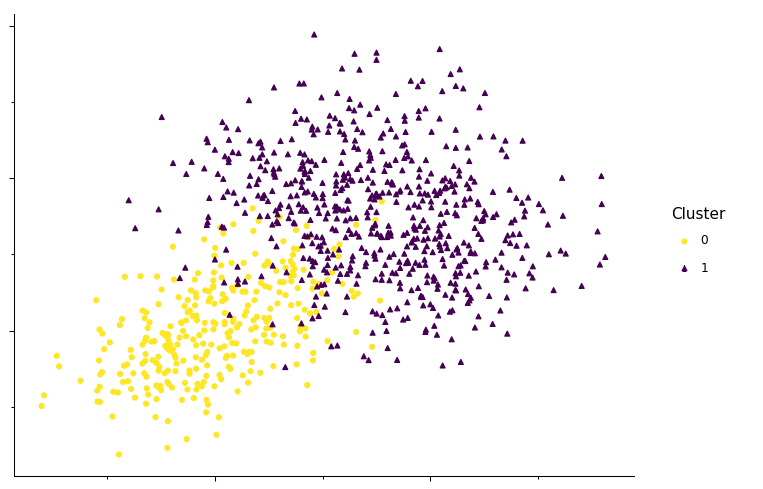

<ggplot: (-9223372036563641379)>

In [12]:
plot_data(non_linear_data)

## Boundaries

[Top](#Navigation)

We now wish to visualize the decision boundaries for the given classifiers.

### Classifiers

In [13]:
features = ['x_0', 'x_1']

In [14]:
X, y = linear_data[features], linear_data.cluster
non_lin_X, non_lin_y = non_linear_data[features], non_linear_data.cluster

Create a dictionary with "name":classifier paires.

In [15]:
lin_clfs = {'LR':LogisticRegression().fit(X, y), 
            'RF':RandomForestClassifier(n_estimators=100, 
                                        max_depth=4).fit(X, y),
            '5NN':KNeighborsClassifier().fit(X, y),
            'SVC':SVC().fit(X, y),
            'SVC-Poly':SVC(kernel='poly').fit(X, y),
            'NB':GaussianNB().fit(X, y)}

non_lin_clfs = {'LR':LogisticRegression().fit(non_lin_X, non_lin_y), 
                'RF':RandomForestClassifier(n_estimators=100, 
                                            max_depth=4).fit(non_lin_X, non_lin_y),
                '5NN':KNeighborsClassifier().fit(non_lin_X, non_lin_y),
                'SVC':SVC().fit(non_lin_X, non_lin_y),
                'SVC-Poly':SVC(kernel='poly').fit(non_lin_X, non_lin_y),
                'NB':GaussianNB().fit(non_lin_X, non_lin_y)}

### Single Classifier

##### Linear Data

Decision boundaries for Logistic regression. We can expect LR to perform well over this data.

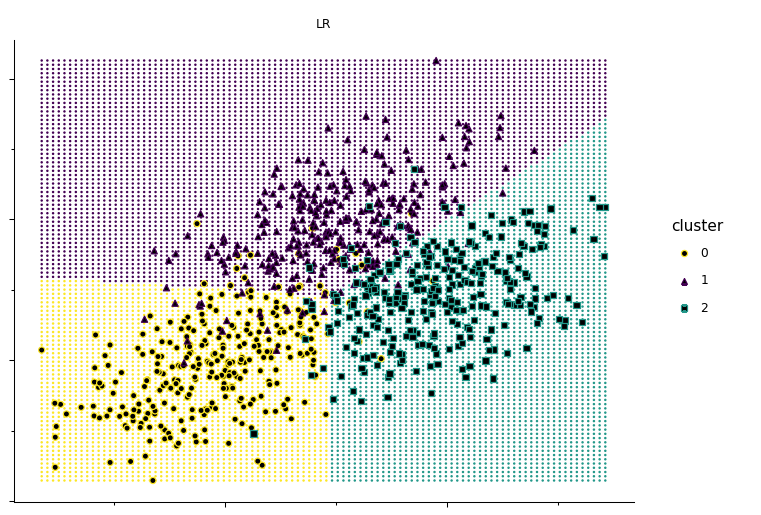

<ggplot: (289678116)>

In [16]:
plot_boundries(lin_clfs['LR'], linear_data, 100, model_name = 'LR')

##### Non-Linear Data

Decision boundaries for Logistic regression. LR is bound to produce linear boundaries between classes.

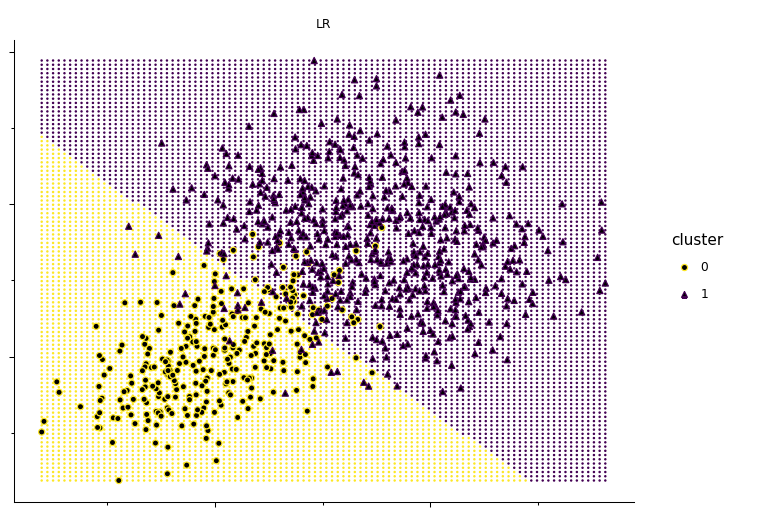

<ggplot: (291308222)>

In [17]:
plot_boundries(non_lin_clfs['LR'], non_linear_data, 100, model_name = 'LR')

### Multiple Classifiers

##### Linear Boundaries

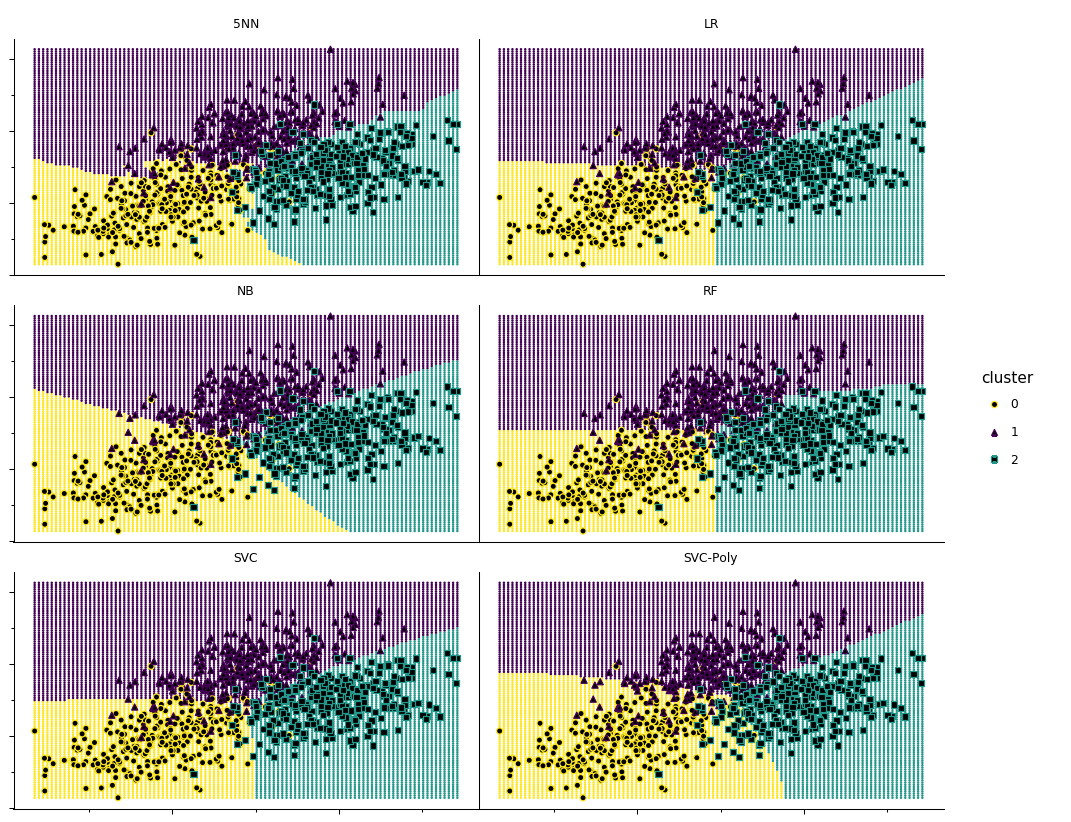

<ggplot: (291908570)>

In [18]:
plot_boundries(lin_clfs, linear_data, 100, figure_size = (12, 10))

##### Non-Linear Boundaries

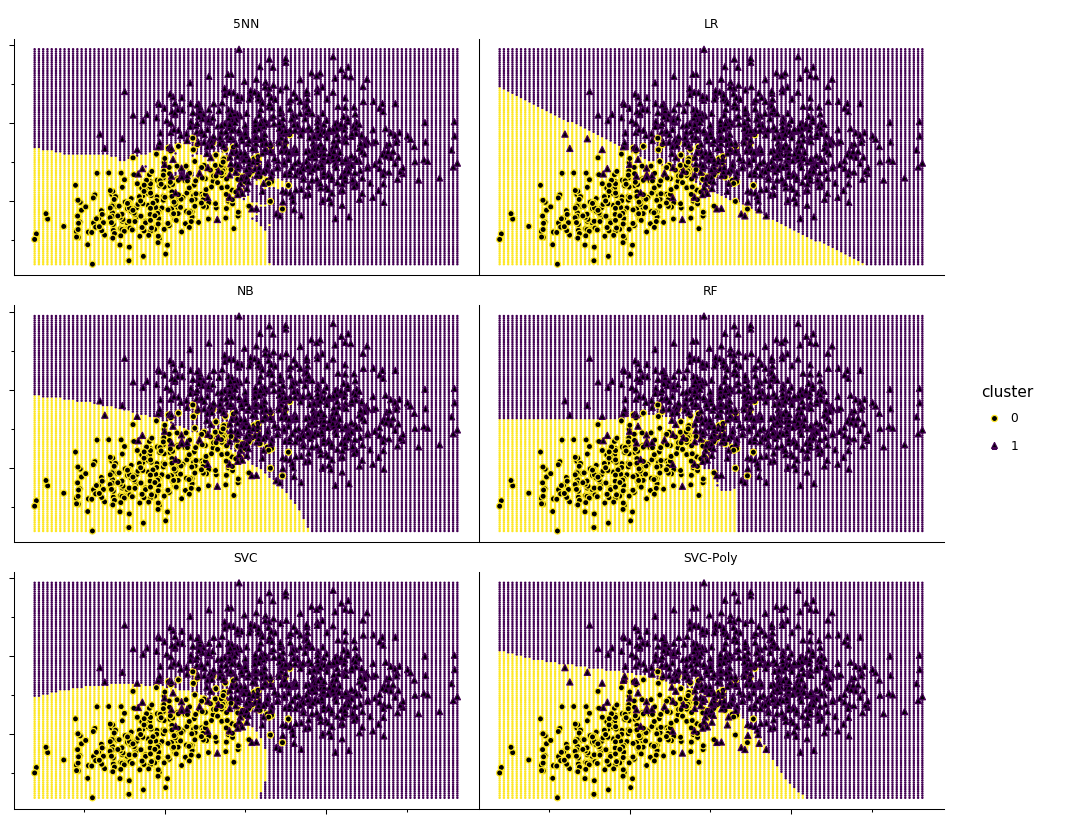

<ggplot: (-9223372029301777485)>

In [19]:
plot_boundries(non_lin_clfs, non_linear_data, 100, figure_size = (12, 10))

### Compare to Bayes Classifier

We now add the optimal decision boundaries, according to our Bayes classifier.

##### Linear Boundaries

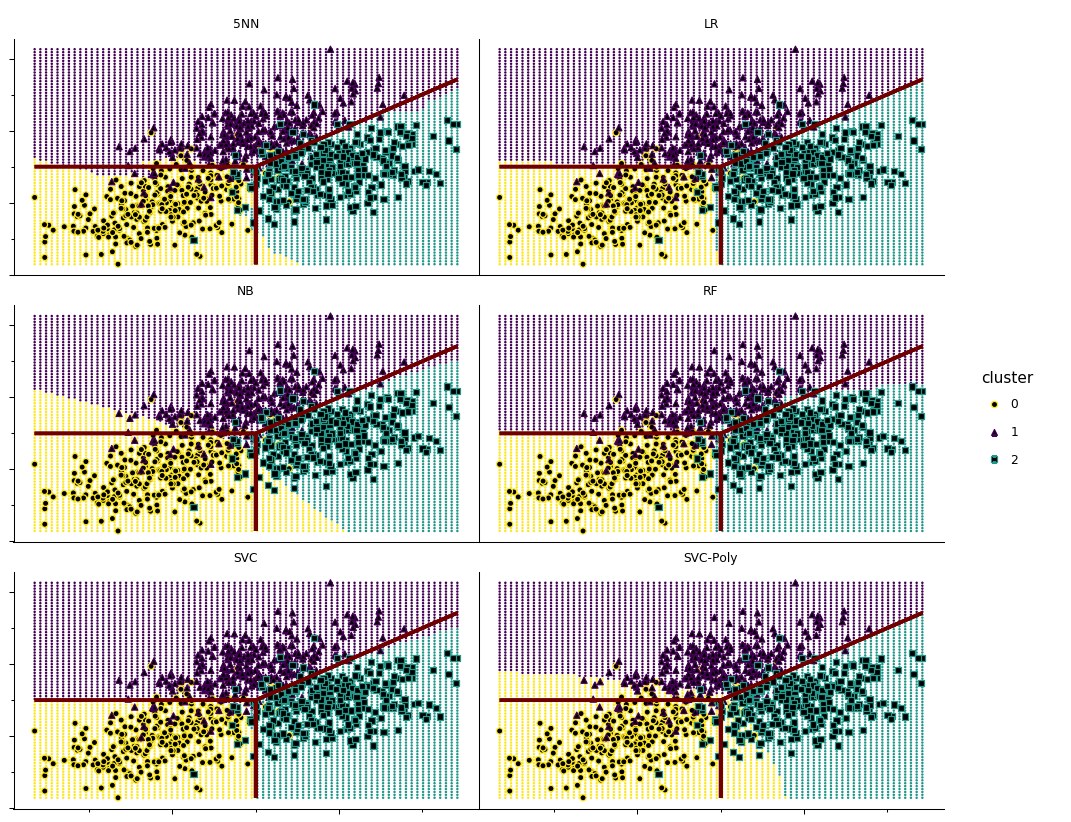

In [27]:
plot_boundries_w_bayes(lin_clfs, linear_data, 75, 
                       lin_cluster_pdf, figure_size = (12, 10),
                       boundary_color = "#700000", linewidths = 2.5)

##### Non-Linear Boundaries

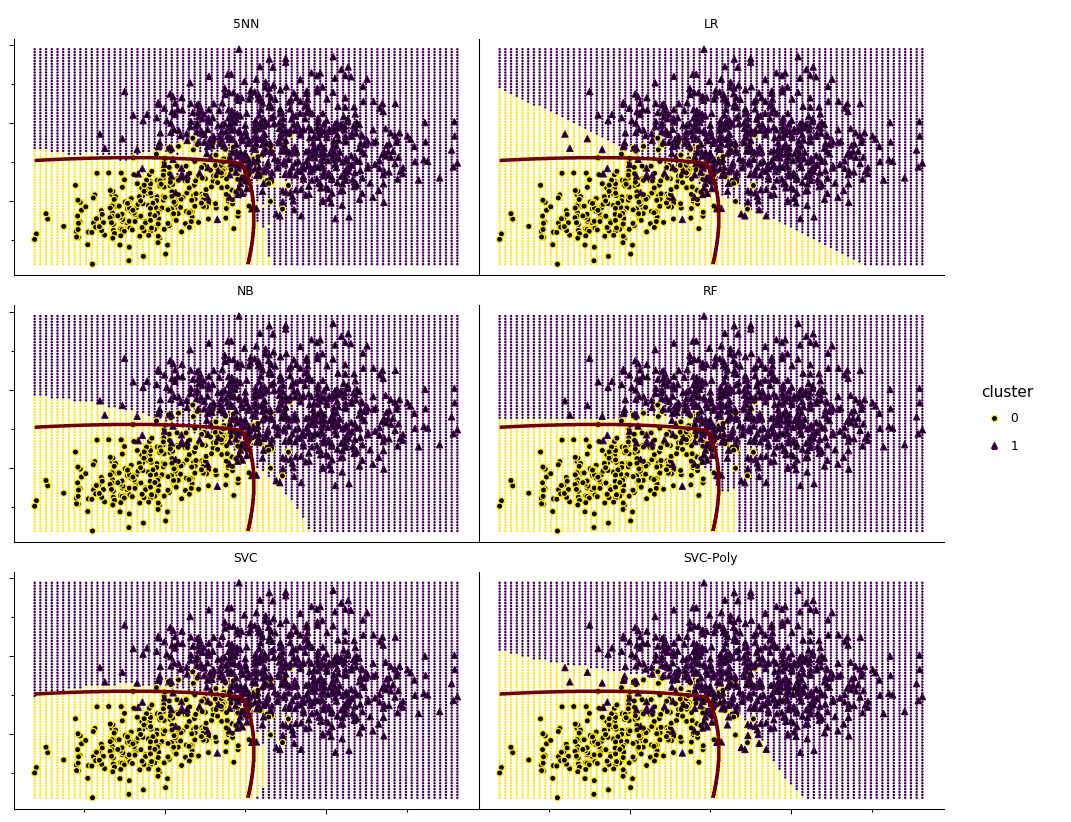

In [31]:
plot_boundries_w_bayes(non_lin_clfs, 
                       non_linear_data, 
                       75, 
                       non_lin_cluster_pdf, 
                       figure_size = (12, 10),
                       boundary_color = "#700000",
                       linewidths = 2.5
                      )

## ToDo

1. Add LDA/QDA